### First set number of cores on machine to use and SSID number to analyse, then run all

In [1]:
# setting variables

cores = 3
SSIDno = 12881289

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.font_manager as fm
import matplotlib
import autotime
%matplotlib inline
%load_ext autotime
#import seaborn as sns
import statsmodels as stm
import statsmodels.formula.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinR
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV as RSCV
# from dask_searchcv import RandomizedSearchCV as DRSCV
# from sklearn.pipeline import Pipeline
from sklearn.metrics.scorer import make_scorer
# from sklearn.preprocessing import MinMaxScaler as MMS
from scipy import stats
from scipy.stats import randint

#from sklearn.tree import export_graphviz
#from IPython.display import Image

## 1. Data processing stage

First, select route files to input based on SSIDno to analyse

### 1a Inputting data and creating dataframe for SSIDno

In [3]:
# Read in stop_times.txt and trips.txt files from NTA data
stop_times_2012 = pd.read_csv('stop_times.txt')
trips_2012 = pd.read_csv('trips.txt')

# Merge by trip_id
merge = pd.merge(stop_times_2012, trips_2012, on='trip_id', how='outer')

# Keep only necessary columns
merge.drop(['arrival_time','departure_time','pickup_type','drop_off_type','service_id','shape_dist_traveled'], axis=1, inplace=True)

# Transform trip_id to route and stop_id to StopID
merge['route_short'] = merge['trip_id'].apply(lambda x: x[x.index('-')+1:])
merge['route_short'] = merge['route_short'].apply(lambda x: x[: x.index('-')])
merge['route_short'] = merge['route_short'].apply(lambda x: str(x).zfill(4))
merge['StopID'] = merge['stop_id'].apply(lambda x: x[-4:])

# Find StopID and the sequence of that shape_id
gb = merge.groupby(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'])
gbc = gb.count()
gbc.reset_index(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'], inplace=True)
transit_shapeID_stopID = gbc.drop(['trip_id','stop_id','route_id','trip_headsign'], axis=1)

# create list of pairs of routes and the SSIDs contained within them
ssid = []
for i in range(len(transit_shapeID_stopID.index)-1):
    temp = transit_shapeID_stopID['StopID'].iloc[i] + transit_shapeID_stopID['StopID'].iloc[i+1]
    ssid.append([ transit_shapeID_stopID['route_short'].iloc[i],temp])
    
SSIDnoStr = str(SSIDno).zfill(8)
routes = [x for x in ssid if SSIDnoStr in x[1]]
routes = [item[0] for item in routes]
routes = list(set(routes))

# Reading in the route CSV files for the required SSID

res = pd.read_csv('Route_XXXX_travel_time_csvs/Blank_Route_travel_time.csv')
route_list = routes
for r in route_list:
    df = pd.read_csv('Route_XXXX_travel_time_csvs/Route_%s_travel_time.csv' % r)
    res = pd.concat([df, res], axis=0) 

time: 6.15 s


In [86]:
# create dataframe for SSIDno

res['SSID'] = res['SSID'].astype('category')
ssid_df = res[res.SSID == SSIDno]
ssid_df.reset_index(inplace=True)
ssid_df = ssid_df.drop('index', axis=1)
ssid_df.shape

(0, 12)

time: 13 ms


In [5]:
ssid_df.memory_usage(deep=True)

Index                   80
Day                 682069
DestStopID           84952
HourFrame            84952
JourneyPatternID    388287
Rain                 84952
SSID                128206
SchoolHoliday        10619
SourceStopID         84952
TimeFrame           711473
TravelTime           84952
VehicleJourneyID     84952
WindSpeed            84952
dtype: int64

time: 8 ms


In [6]:
# add leading zeroes to JourneyPatternID

ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.astype('object')
ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.apply(lambda x: str(x).zfill(8))

time: 9 ms


### 1b Adding extra features and altering/dropping existing ones

In [7]:
# adding Xbuses feature - boolean feature indicating whether or not the JourneyPatternID represents an express (X) bus

ssid_df['XBuses'] = ssid_df[ssid_df["JourneyPatternID"].str.find("X") > 0].sum(axis=1) > 0
ssid_df["XBuses"].fillna(False, inplace=True)
ssid_df['XBuses'] = ssid_df['XBuses'].astype('int')

time: 12 ms


In [8]:
# adding JPID_length feature - represents the total number of stops traversed by this JourneyPatternID along its entire route

JPIDL = pd.read_csv('JPID_Length.csv')
JPIDL = JPIDL.drop('Unnamed: 0', axis=1)
ssid_df = pd.merge(left=ssid_df ,right=JPIDL, how='left', left_on='JourneyPatternID', right_on='JourneyPatternID')
ssid_df = ssid_df.dropna()
ssid_df.shape

(10619, 14)

time: 19 ms


In [9]:
# NOTE: feature currently not being used due to issues with inputting it to the model

# adding JPID_Freq feature - represents how often in the given data this JourneyPatternID traversed this segment

# ssid_df['JPID_Freq'] = ssid_df.groupby(['JourneyPatternID'])['JourneyPatternID'].transform('count')

Error in callback <bound method LineWatcher.stop of <autotime.LineWatcher object at 0x000000000814DF98>> (for post_run_cell):


AssertionError: 

In [10]:
# removing non-holiday-period weekends from SchoolHoliday feature to avoid multi-collinearity issues

ssid_df['SchoolHoliday'] = ssid_df['SchoolHoliday'].astype('int')
ssid_df['SchoolHoliday'] = np.where(ssid_df['TimeFrame'].isin(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)

time: 3 ms


In [11]:
# fetching SSID number from dataframe for CSV file naming purposes

res.SSID = res.SSID.apply(lambda x: str(int(x)).zfill(8))
r = ssid_df.loc[0, 'SSID'] 

time: 14 ms


In [12]:
# dropping unneeded columns

ssid_df = ssid_df.drop(['SourceStopID', 'DestStopID', 'VehicleJourneyID', 'JourneyPatternID', 'SSID'], axis=1)

# reordering remaining columns

ssid_df = ssid_df[['TravelTime', 'Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]

time: 5 ms


In [13]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,Day,HourFrame
0,64,0.000000,15.0,66,0,0,Tuesday,8
1,41,0.000000,15.0,66,0,0,Tuesday,8
2,41,0.000000,17.5,66,0,0,Tuesday,11
3,21,0.000000,15.5,66,0,0,Tuesday,9
4,41,0.000000,15.5,66,0,0,Tuesday,9
5,62,0.000000,16.5,66,0,0,Tuesday,10
6,41,0.000000,17.0,66,0,0,Tuesday,13
7,41,0.000000,15.5,66,0,0,Tuesday,9
8,37,0.000000,15.5,66,0,0,Tuesday,9
9,19,0.000000,15.0,66,0,0,Tuesday,8


time: 24 ms


In [14]:
# assigning appropriate datatypes where necessary

ssid_df['Day'] = ssid_df['Day'].astype('category')
ssid_df['HourFrame'] = ssid_df['HourFrame'].astype('category')
ssid_df['JPID_length'] = ssid_df['JPID_length'].astype('int')

time: 34 ms


In [15]:
# removing any constant features
# code from: https://stackoverflow.com/questions/20209600/panda-dataframe-remove-constant-column

ssid_df = ssid_df.loc[:,ssid_df.apply(pd.Series.nunique) != 1]

time: 10 ms


In [16]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,Day,HourFrame
0,64,0.000000,15.0,66,0,Tuesday,8
1,41,0.000000,15.0,66,0,Tuesday,8
2,41,0.000000,17.5,66,0,Tuesday,11
3,21,0.000000,15.5,66,0,Tuesday,9
4,41,0.000000,15.5,66,0,Tuesday,9
5,62,0.000000,16.5,66,0,Tuesday,10
6,41,0.000000,17.0,66,0,Tuesday,13
7,41,0.000000,15.5,66,0,Tuesday,9
8,37,0.000000,15.5,66,0,Tuesday,9
9,19,0.000000,15.0,66,0,Tuesday,8


time: 23 ms


In [17]:
# save as csv

ssid_df.to_csv('SSID_CSVs/SSID_%s.csv' % r)

time: 136 ms


## 1c. Dropping Outliers

Visualising range of data first

Histiogram of values (x-axis is number of seconds)

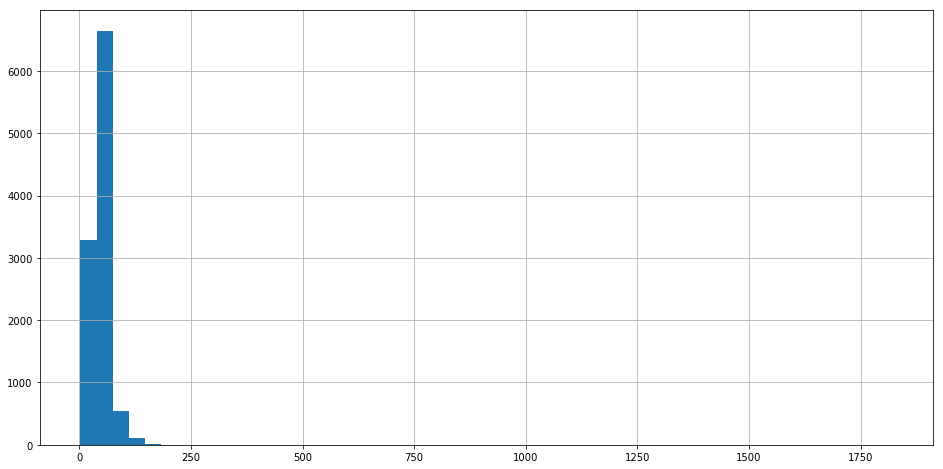

time: 217 ms


In [18]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Boxplot to check for outliers

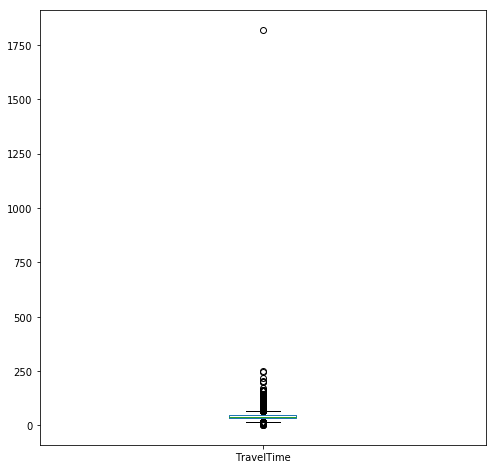

time: 166 ms


In [19]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

In [20]:
# Checking stats for TravelTime

ssid_df.TravelTime.describe()

count    10619.000000
mean        42.558245
std         26.245258
min          2.000000
25%         35.000000
50%         40.000000
75%         48.000000
max       1820.000000
Name: TravelTime, dtype: float64

time: 6 ms


Dropping outliers

In [21]:
# loading table of minimum times to traverse segments at 65kmph

find_lb = pd.read_csv('use_speed_and_distance_get_outlier_bound.csv')

# extracting value for this segment, to use as lower bound for outlier removal

lb = find_lb.loc[find_lb['SSID'] == SSIDno, 'min_sec'].iloc[0]
print(lb)

12.6692604194
time: 11 ms


In [22]:
# make a copy of original df

trimssid_df = ssid_df.copy()

# Remove TravelTime upper bound outliers beyond a conservative 2 x IQR, and lowerbound below 'lb'

ub = trimssid_df.quantile(q=.75) + (2*(trimssid_df.quantile(q=.75)-trimssid_df.quantile(q=.25)))
trimssid_df['OutlierTT'] = (trimssid_df['TravelTime'] < lb) | (trimssid_df['TravelTime'] > ub['TravelTime'])

# Outlier rows counted

print("There will be", trimssid_df[(trimssid_df['OutlierTT'] == True)].shape[0], "outliers dropped.")

There will be 700 outliers dropped.
time: 14 ms


In [23]:
# dropping outliers

trimssid_df = trimssid_df[trimssid_df.OutlierTT != True]
trimssid_df.sort_values(['TravelTime'], ascending=False, inplace=True)
trimssid_df = trimssid_df.drop(['OutlierTT'], axis=1)
trimssid_df.reset_index(inplace=True)
trimssid_df = trimssid_df.drop('index', axis=1)
trimssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,Day,HourFrame
0,74,0.000000,3.0,53,0,Wednesday,19
1,74,0.000000,24.0,66,0,Monday,15
2,74,0.000000,3.5,53,0,Saturday,15
3,74,0.000000,12.0,66,0,Friday,16
4,74,0.000000,6.5,66,0,Tuesday,7
5,74,0.000000,11.5,66,0,Friday,17
6,74,0.000000,9.5,66,0,Thursday,19
7,74,0.000000,6.5,66,0,Wednesday,7
8,74,0.266602,11.5,66,0,Tuesday,8
9,74,0.000000,10.5,76,0,Thursday,15


time: 59 ms


In [24]:
# Create TT mean/median value variables, to use in calculating mean/median absolute percentage accuracy scores
# and for horizontal lines in the charts below to represent the mean/medium

ssid_df = trimssid_df
ssid_df_mean = ssid_df.TravelTime.mean()
ssid_df_median  = ssid_df.TravelTime.median()
ssid_df.TravelTime.describe()

count    9919.000000
mean       38.938804
std        13.620308
min        13.000000
25%        26.000000
50%        39.000000
75%        42.000000
max        74.000000
Name: TravelTime, dtype: float64

time: 8 ms


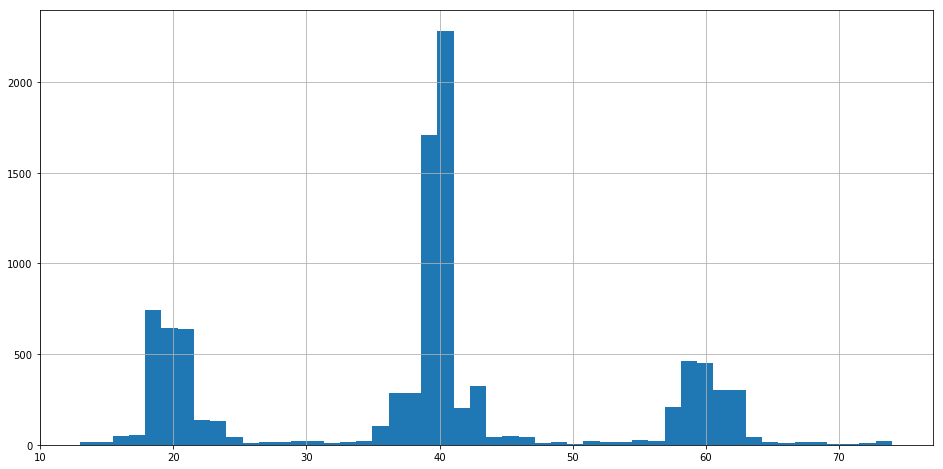

time: 207 ms


In [25]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Bocplot post-outlier dropping

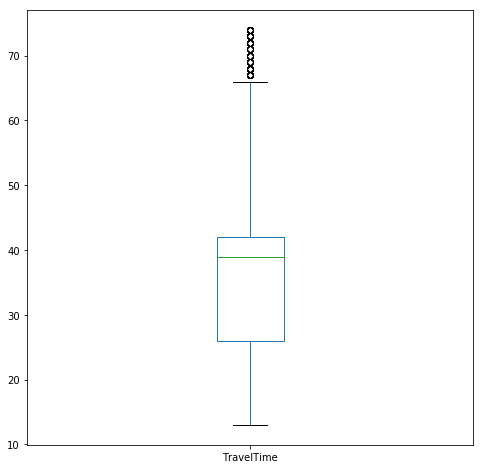

time: 161 ms


In [26]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

## 2. Visualising the data

### 2ai Bar plot for mean TravelTime per HourFrame

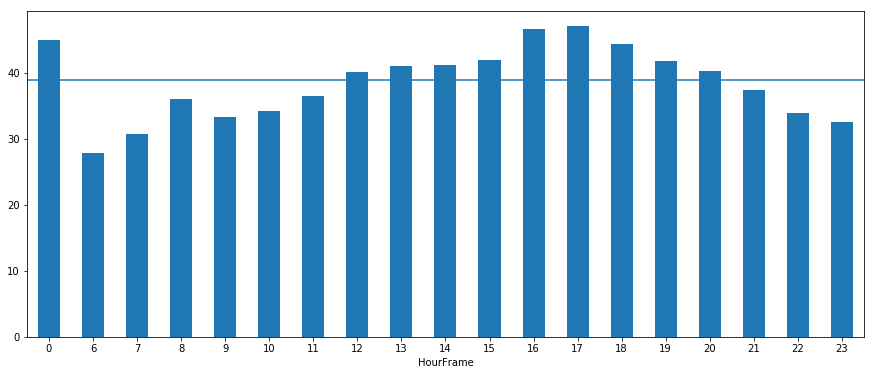

time: 176 ms


In [27]:
mean_HF = ssid_df.groupby('HourFrame')['TravelTime'].mean()
mean_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2aii Bar plot for median TravelTime per HourFrame

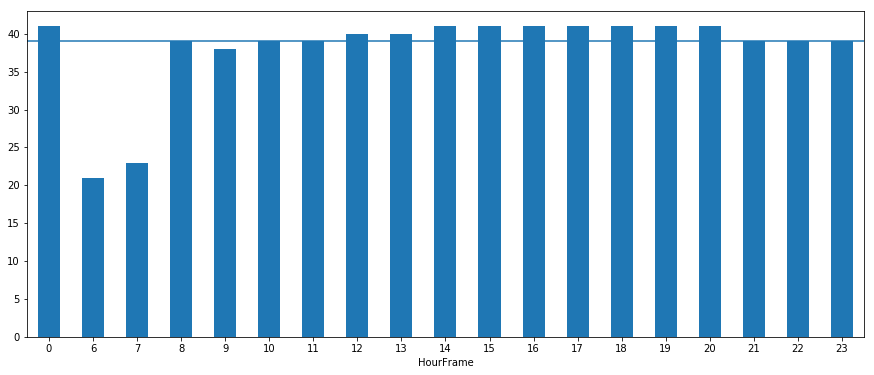

time: 186 ms


In [28]:
med_HF = ssid_df.groupby('HourFrame')['TravelTime'].median()
med_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

### 2bi Bar plot for mean TravelTime per Day

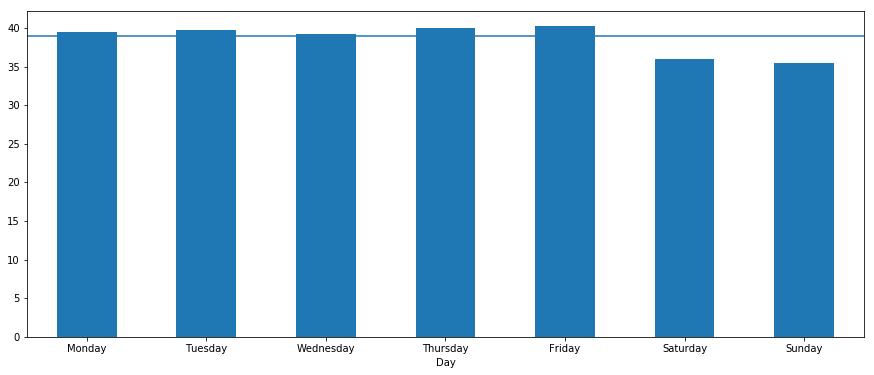

time: 147 ms


In [29]:
mean_Day = ssid_df.groupby('Day')['TravelTime'].mean()
mean_Day=mean_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

mean_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean

coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bii Bar plot for median TravelTime per HourFrame

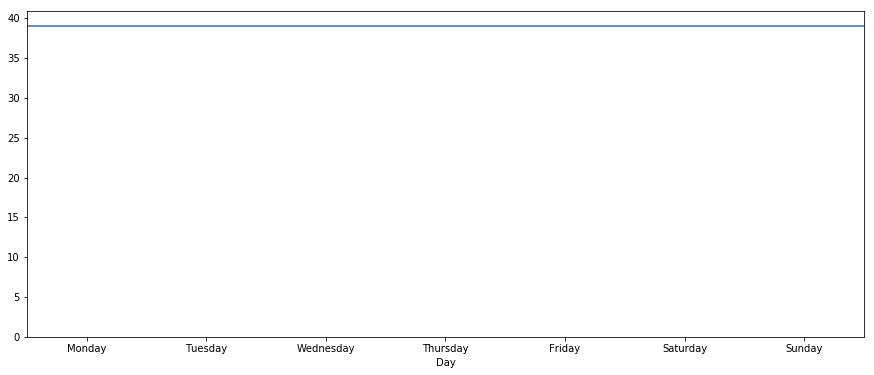

time: 233 ms


In [87]:
med_Day = ssid_df.groupby('Day')['TravelTime'].median()

med_Day=med_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
med_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

### 2ci Bar plot for mean TravelTime when SchoolHoliday true/false

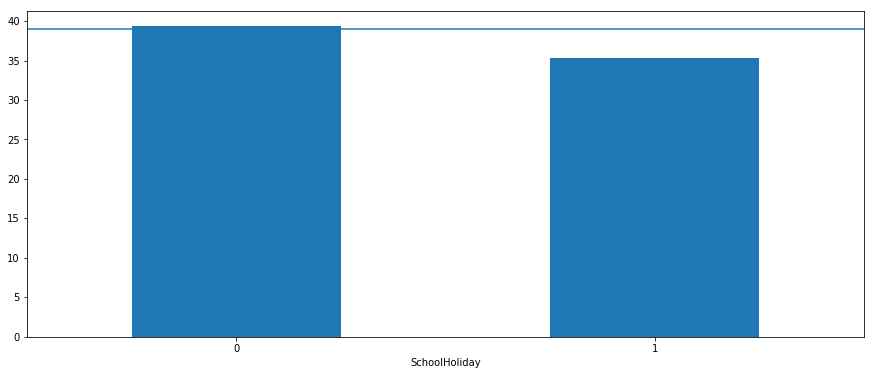

time: 164 ms


In [31]:
mean_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].mean()
mean_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2cii Bar plot for median TravelTime when SchoolHoliday true/false

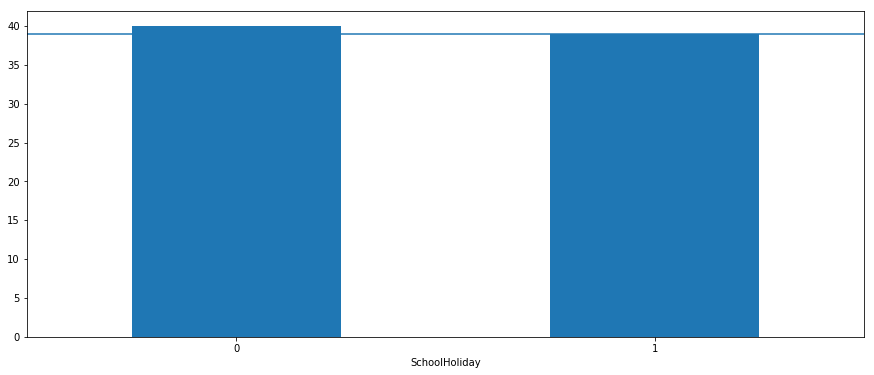

time: 130 ms


In [32]:
med_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].median()
med_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Splitting data into 70% for training and 30% for testing

## 3 Model training (Scikit-learn)

First we need to dreate dummy variables for categorical features, and split into test and training sets

### 3.1 Prepare data for modelling via Scikit-learn

In [33]:
# create dummy variables from HourFrame and Day using get_dummies
# dropping first values to avoid multicollinearity (Day = Friday, Hour = 0 or 6 or 7, depending on SSID)

Day_dummies = pd.get_dummies(ssid_df.Day, prefix='Day')
HF_dummies = pd.get_dummies(ssid_df.HourFrame, prefix='HF')

# concatenate the dummy variable columns onto the original DataFrame and drop the original features
ssid_df = pd.concat([ssid_df, HF_dummies, Day_dummies], axis=1)
ssid_df = ssid_df.drop(['HourFrame', 'Day'], axis=1)
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,HF_0,HF_6,HF_7,HF_8,HF_9,...,HF_21,HF_22,HF_23,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,74,0.000000,3.0,53,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,74,0.000000,24.0,66,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,74,0.000000,3.5,53,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,74,0.000000,12.0,66,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,74,0.000000,6.5,66,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5,74,0.000000,11.5,66,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,74,0.000000,9.5,66,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,74,0.000000,6.5,66,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8,74,0.266602,11.5,66,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
9,74,0.000000,10.5,76,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


time: 52 ms


In [34]:
# prepare a list containing all remaining features bar the target
pred_features = list(ssid_df)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'JPID_length', 'SchoolHoliday', 'HF_0', 'HF_6', 'HF_7', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 2 ms


In [35]:
# prepare target/predictive feature variables for use in scikit-learn modelling

X = ssid_df[pred_features]
y = ssid_df['TravelTime']

time: 3 ms


In [36]:
# split the data into training portion (70%) and final testing potion (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 38)

time: 6 ms


### 3bi Linear Regression model (via scikit-learn) - training - default parameters

In [37]:
lr = LinR(n_jobs = cores)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

time: 18 ms


In [38]:
lr_pred = lr.predict(X_train)
lr_rsq = metrics.r2_score(y_train, lr_pred)
print ("The R-squared value of the Linear Regression model is", lr_rsq)

The R-squared value of the Linear Regression model is 0.160115608909
time: 5 ms


In [39]:
lr_mae = metrics.mean_absolute_error(y_train, lr_pred)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage error is", (((lr_mae)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 9.94736766966
The mean absolute percentage error is 25.5461559354
time: 4 ms


In [40]:
lr_mdae = metrics.median_absolute_error(y_train, lr_pred)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage error is", (((lr_mdae)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 8.22192382813
The median absolute percentage error is 21.0818559696
time: 11 ms


### 3bii Linear Regression model (via scikit-learn) - testing - default parameters

In [41]:
lr_preda = lr.predict(X_test)
lr_rsqa = metrics.r2_score(y_test, lr_preda)
print ("The R-squared value of the Linear Regression model is", lr_rsqa)

The R-squared value of the Linear Regression model is 0.160056727045
time: 13 ms


In [42]:
lr_maea = metrics.mean_absolute_error(y_test, lr_preda)
print ("The mean absolute error of the Linear Regression model is", lr_maea)
print ("The mean absolute percentage error is", (((lr_maea)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 9.9881086452
The mean absolute percentage error is 25.6507841494
time: 8 ms


In [43]:
lr_mdaea = metrics.median_absolute_error(y_test, lr_preda)
print ("The median absolute error of the Linear Regression model is", lr_mdaea)
print ("The median absolute percentage error is", (((lr_mdaea)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 8.20642089844
The median absolute percentage error is 21.0421048678
time: 12 ms


### 3ci Support Vector Machine Regression with RBF Kernel model - training - default parameters

In [44]:
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 2.73 s


In [45]:
svr_rbf_pred = svr_rbf.predict(X_train)
svr_rbf_rsq = metrics.r2_score(y_train, svr_rbf_pred)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsq)

The R-squared value of the SVR with RBF Kernel model is 0.0445230882034
time: 1.82 s


In [46]:
svr_rbf_mae = metrics.mean_absolute_error(y_train, svr_rbf_pred)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_mae)
print ("The mean absolute percentage error is", (((svr_rbf_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 9.62081765733
The mean absolute percentage error is 24.7075323102
time: 3 ms


In [47]:
svr_rbf_mdae = metrics.median_absolute_error(y_train, svr_rbf_pred)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdae)
print ("The median absolute percentage error is", (((svr_rbf_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 3.4076377868
The median absolute percentage error is 8.73753278667
time: 3 ms


### 3cii Support Vector Machine Regression with RBF Kernel model - testing - default parameters

In [48]:
svr_rbf_preda = svr_rbf.predict(X_test)
svr_rbf_rsqa = metrics.r2_score(y_test, svr_rbf_preda)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsqa)

The R-squared value of the SVR with RBF Kernel model is 0.0356053197661
time: 782 ms


In [49]:
svr_rbf_maea = metrics.mean_absolute_error(y_test, svr_rbf_preda)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_maea)
print ("The mean absolute percentage error is", (((svr_rbf_maea)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 9.84749201257
The mean absolute percentage error is 25.2896620372
time: 2 ms


In [50]:
svr_rbf_mdaea = metrics.median_absolute_error(y_test, svr_rbf_preda)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdaea)
print ("The median absolute percentage error is", (((svr_rbf_mdaea)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 3.84168247658
The median absolute percentage error is 9.85046788867
time: 4 ms


### 3di Gradient Boosting Regression model - training - default parameters

In [51]:
gbr = GBR()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 338 ms


In [52]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.115560171894
Rain 	 0.0703224222007
JPID_length 	 0.0640738785318
Day_Sunday 	 0.0593752195375
HF_9 	 0.0572763343304
HF_7 	 0.0539818579482
HF_10 	 0.047967685372
Day_Saturday 	 0.0467286850591
HF_6 	 0.0457951695673
HF_17 	 0.0424626040407
HF_22 	 0.0416751914363
HF_23 	 0.0415729034382
SchoolHoliday 	 0.0406864336276
HF_16 	 0.0375907192105
HF_8 	 0.0360633716251
HF_18 	 0.0326208805129
HF_11 	 0.0262372914627
HF_19 	 0.0204937743203
Day_Friday 	 0.0188949473739
HF_21 	 0.0154196657098
HF_14 	 0.0144103331777
HF_15 	 0.0136166476284
Day_Thursday 	 0.0112981474941
HF_12 	 0.00998611601889
Day_Wednesday 	 0.00880920621646
Day_Monday 	 0.00869395492555
Day_Tuesday 	 0.00823789810363
HF_13 	 0.00711311753842
HF_20 	 0.00303537169827
HF_0 	 0.0
time: 69 ms


In [53]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsq)

The R-squared value of the Gradient Boosting Regression model is 0.192795096697
time: 13 ms


In [54]:
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 9.57525326249
The mean absolute percentage error is 24.5905169174
time: 3 ms


In [55]:
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 7.48949251641
The median absolute percentage error is 19.2038269652
time: 4 ms


### 3dii Gradient Boosting Regression model - - testing - default parameters

In [56]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsqa)

The R-squared value of the Gradient Boosting Regression model is 0.168455228392
time: 7 ms


In [57]:
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 9.76342946238
The mean absolute percentage error is 25.0737782892
time: 3 ms


In [58]:
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 7.61706658586
The median absolute percentage error is 19.5309399637
time: 2 ms


### 3ei Random Forest Regression model (all default) - training - default parameters

In [129]:
rfr = RFR(n_jobs = cores)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

time: 111 ms


In [130]:
indices = np.argsort(rfr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", rfr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.263484377164
JPID_length 	 0.214206799549
Rain 	 0.0819479392746
HF_17 	 0.0359275987295
HF_16 	 0.0309108915892
SchoolHoliday 	 0.0282652578242
HF_18 	 0.0279473800618
Day_Thursday 	 0.0261084899378
Day_Wednesday 	 0.0255040136788
Day_Tuesday 	 0.0251673488298
Day_Saturday 	 0.024364971374
Day_Sunday 	 0.0221029305607
Day_Friday 	 0.021521884695
Day_Monday 	 0.0184252031415
HF_7 	 0.0142053154021
HF_9 	 0.011887317695
HF_12 	 0.0114726912673
HF_13 	 0.0113834540221
HF_19 	 0.0111502708799
HF_14 	 0.0108897887899
HF_15 	 0.0107194050243
HF_6 	 0.0105962957555
HF_10 	 0.0105909983167
HF_22 	 0.00940690464092
HF_8 	 0.0093284150488
HF_23 	 0.00905838816547
HF_20 	 0.00835204190591
HF_11 	 0.00802832185858
HF_21 	 0.0069705499619
HF_0 	 7.47548563678e-05
time: 3.14 s


In [131]:
rfr_pred = rfr.predict(X_train)
rfr_rsq = metrics.r2_score(y_train, rfr_pred)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsq)

The R-squared value of the Random Forest Regression model is 0.497571548239
time: 105 ms


In [132]:
rfr_mae = metrics.mean_absolute_error(y_train, rfr_pred)
print ("The mean absolute error of the Random Forest Regression model is", rfr_mae)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 7.2886563017
The mean absolute percentage error is 18.718233469
time: 3 ms


In [133]:
rfr_mdae = metrics.median_absolute_error(y_train, rfr_pred)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdae)
print ("The median absolute percentage error is", (((rfr_mdae)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 5.87357142857
The median absolute percentage error is 15.0604395604
time: 2 ms


### 3eii Random Forest Regression model (all default) - testing - default parameters

In [134]:
rfr_preda = rfr.predict(X_test)
rfr_rsqa = metrics.r2_score(y_test, rfr_preda)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsqa)

The R-squared value of the Random Forest Regression model is -0.0987316288024
time: 104 ms


In [135]:
rfr_maea = metrics.mean_absolute_error(y_test, rfr_preda)
print ("The mean absolute error of the Random Forest Regression model is", rfr_maea)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 11.3573684115
The mean absolute percentage error is 18.718233469
time: 2 ms


In [136]:
rfr_mdaea = metrics.median_absolute_error(y_test, rfr_preda)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdaea)
print ("The median absolute percentage error is", (((rfr_mdaea)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 9.88666666667
The median absolute percentage error is 25.3504273504
time: 2 ms


## 4 All models bar Linear Regression - parameter tuning with RandomizedSearchCV

### 4a SVR with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [67]:
svr = SVR()

# Parameter settings taken from:
# http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/svm/plot_svm_parameters_selection.html
# https://www.quora.com/What-is-an-appropriate-grid-search-range-for-optimizing-the-parameter-epsilon-in-epsilon-support-vector-regression

C_range = 10. ** np.arange(-3, 7)
gamma_range = 10. ** np.arange(-5, 4)

param_svr = {'C': C_range,
            'gamma': gamma_range,
            'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]}

time: 5 ms


In [68]:
svr_rsearch = RSCV(svr, param_distributions=param_svr, n_iter=38, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
svr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03,   1.00000e+04,
         1.00000e+05,   1.00000e+06]), 'gamma': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          scoring=make_scorer(median_absolute_error, greater_is_better=False),
          verbose=0)

time: 18min 54s


In [69]:
print("Best parameters set found:")
print(svr_rsearch.best_params_)

Best parameters set found:
{'gamma': 0.0001, 'epsilon': 1, 'C': 0.01}
time: 1e+03 µs


In [70]:
svr_train_MdAE = abs(svr_rsearch.best_score_)
svr_train_MdAPE = (svr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", svr_train_MdAE)
print ("Best MdAPE found is", str(round(svr_train_MdAPE, 3)) + "%")

Best MdAE found is 3.00018498566
Best MdAPE found is 7.693%
time: 3 ms


In [71]:
svr_rsearch_table = pd.DataFrame(svr_rsearch.cv_results_)
svr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
svr_rsearch_table = svr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_C', 'param_gamma', 'param_epsilon', 'mean_fit_time', 'mean_score_time']]
svr_rsearch_table.reset_index(inplace=True)
svr_rsearch_table = svr_rsearch_table.drop('index', axis=1)

print("Full ranked results for SVR RandomizedSearchCV:")
svr_rsearch_table

Full ranked results for SVR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_C,param_gamma,param_epsilon,mean_fit_time,mean_score_time
0,1,-3.000179,-3.000185,0.01,0.0001,1,1.3220,0.2168
1,2,-2.999903,-3.000964,0.001,1,1,1.4394,0.2260
2,3,-3.000397,-3.003080,0.001,0.1,1,1.3922,0.2238
3,4,-3.005844,-3.008687,1,0.0001,1,1.4256,0.2384
4,5,-3.272902,-3.262780,0.1,100,0.5,2.6832,0.5288
5,6,-3.450045,-3.278295,0.01,0.1,0.5,1.6674,0.2742
6,7,-3.446791,-3.291694,0.1,0.001,0.5,1.6098,0.2736
7,8,-3.339335,-3.396394,10,0.001,1,1.4446,0.2338
8,9,-2.704816,-3.415399,1,100,0.1,3.0402,0.5714
9,10,-2.717127,-3.456677,1,1000,0,3.0348,0.5726


time: 28 ms


In [72]:
# Running model on 30% test set

svr_test_pred = svr_rsearch.best_estimator_.predict(X_test)

svr_test_MdAE = metrics.median_absolute_error(y_test, svr_test_pred)
svr_test_MdAPE = (svr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", svr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(svr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 3.00059936769
MdAPE of best model on the test set is 7.694%
time: 588 ms


### 4b Gradient Boosted Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [73]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(50, 5000),
            'max_depth': stats.randint(5, 8),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.6)}

time: 4 ms


In [74]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=38, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000029347E10>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000029363160>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000029350828>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000029350630>, 'learning_rate': <scipy.stats._distn_inf

time: 19min 27s


In [75]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.041158124833591749, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 644, 'n_estimators': 2810}
time: 1e+03 µs


In [76]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

Best MdAE found is 8.56607504025
Best MdAPE found is 21.964%
time: 4 ms


In [77]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,-7.988911,-8.566075,2810,5,10,644,0.0411581,15.4882,0.0628
1,2,-8.185860,-8.671062,1794,5,75,708,0.0556504,9.3428,0.0380
2,3,-7.859939,-8.673773,3893,6,45,752,0.083984,23.7740,0.0952
3,4,-8.105283,-8.680915,2474,5,96,428,0.10831,12.5738,0.0468
4,5,-8.022397,-8.689382,2836,5,99,356,0.170952,14.9670,0.0524
5,6,-7.532317,-8.721327,3118,7,18,331,0.147904,23.8400,0.0846
6,7,-8.030687,-8.736751,2609,5,77,906,0.4,12.8074,0.0458
7,8,-7.753952,-8.748637,1357,6,92,587,0.438404,8.0798,0.0308
8,9,-7.710007,-8.754023,3901,6,11,600,0.2396,23.6102,0.0872
9,10,-8.014766,-8.764983,1680,5,71,582,0.358365,8.4940,0.0306


time: 32 ms


In [78]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", gbr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 8.35647671633
MdAPE of best model on the test set is 21.427%
time: 129 ms


In [89]:
metrics.r2_score(y_test, gbr_test_pred)

0.15738210479539982

time: 4 ms


### 4c Random Forest Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [79]:
rfr = RFR()

param_rfr = {'n_estimators': stats.randint(50, 5000),
            'max_depth': stats.randint(4, 8),
            'min_samples_leaf': stats.randint(1, 20),
            'min_samples_split': stats.randint(1.0, 100)}

time: 5 ms


In [80]:
rfr_rsearch = RSCV(rfr, param_distributions=param_rfr, n_iter=38, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
rfr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000029965F60>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000029965CC0>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000029965E48>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000029965438>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          sco

time: 10min 16s


In [81]:
print("Best parameters set found:")
print(rfr_rsearch.best_params_)

Best parameters set found:
{'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 589}
time: 1 ms


In [82]:
rfr_train_MdAE = abs(rfr_rsearch.best_score_)
rfr_train_MdAPE = (rfr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", rfr_train_MdAE)
print ("Best MdAPE found is", str(round(rfr_train_MdAPE, 3)) + "%")

Best MdAE found is 7.03472349865
Best MdAPE found is 18.038%
time: 3 ms


In [83]:
rfr_rsearch_table = pd.DataFrame(rfr_rsearch.cv_results_)
rfr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
rfr_rsearch_table = rfr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_fit_time', 'mean_score_time']]
rfr_rsearch_table.reset_index(inplace=True)
rfr_rsearch_table = rfr_rsearch_table.drop('index', axis=1)

print("Full ranked results for rfr RandomizedSearchCV:")
rfr_rsearch_table

Full ranked results for rfr RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_fit_time,mean_score_time
0,1,-6.802226,-7.034723,589,4,10,20,1.9938,0.0368
1,2,-6.798024,-7.035025,4597,4,9,9,15.6022,0.2894
2,3,-6.779736,-7.040404,545,4,4,24,1.8270,0.0342
3,4,-6.900318,-7.058853,1453,4,18,62,4.8926,0.0912
4,5,-6.825048,-7.062477,4590,4,4,73,15.4776,0.3108
5,6,-6.842635,-7.065255,2312,4,2,84,7.7682,0.1450
6,7,-6.829911,-7.065371,1369,4,15,7,4.6574,0.0858
7,8,-6.947820,-7.101497,4934,5,10,5,19.4954,0.3698
8,9,-6.940193,-7.109038,3122,5,10,33,12.4668,0.2254
9,10,-6.938146,-7.130293,1760,5,6,51,6.9264,0.1212


time: 26 ms


In [84]:
# Running model on 30% test set

rfr_test_pred = rfr_rsearch.best_estimator_.predict(X_test)

rfr_test_MdAE = metrics.median_absolute_error(y_test, rfr_test_pred)
rfr_test_MdAPE = (rfr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", rfr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(rfr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 7.18344148737
MdAPE of best model on the test set is 18.419%
time: 63 ms


In [88]:
metrics.r2_score(y_test, rfr_test_pred)

0.09221189602696811

time: 97 ms
